In [8]:
from transformers import AutoTokenizer, AutoModel, utils
from bertviz import head_view, model_view

import torch
import numpy as np

from util.model import load_model, get_device_memory_report
from util.data import load_grammar_data, load_hidden_data
from util.model import clear_cuda_cache, get_device_memory_report

from tqdm import tqdm

import os
import gc

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
get_device_memory_report(device)

Device: cuda [NVIDIA RTX 6000 Ada Generation]
Free Memory: 47.08/47.50 GB [99.11%]


In [11]:
def total_variation_distance(P, Q, perm, last_layer_only=True):
    Q = Q[-1][perm]
    P = P[-1]
    return np.sum(np.abs(P - Q))

def get_entropy(P):
    P = P[P > 0]
    return -np.sum(P * np.log(P))

def entropy_distance(P, Q, perm):
    Q = Q[-1][perm]
    P = P[-1]

    P_entropy = get_entropy(P)
    Q_entropy = get_entropy(Q)
    # Q_entropy = get_entropy(Q)

    return P_entropy - Q_entropy

In [12]:
from sklearn.preprocessing import MinMaxScaler

def get_divergences(good_attentions, bad_attentions, perm_idx, dist_func=total_variation_distance):

    divergences = np.zeros((len(good_attentions), good_attentions[0].shape[0], good_attentions[0].shape[1]))
    for i, (good_attention, bad_attention) in tqdm(enumerate(zip(good_attentions, bad_attentions))):
        for n_layer in range(good_attention.shape[0]):
            for n_head in range(good_attention.shape[1]):
                good_attention_dist = good_attention[n_layer, n_head]
                bad_attention_dist = bad_attention[n_layer, n_head]
                divergences[i, n_layer, n_head] = dist_func(good_attention_dist, bad_attention_dist, perm_idx[i])
    return np.array(divergences)

def get_normalized_divergences(good_attentions, bad_attentions, perm_idx=None, dist_func=total_variation_distance, normalize=True):
    divergences = get_divergences(good_attentions, bad_attentions, perm_idx, dist_func)
    divergences = divergences.mean(axis=0)
    if normalize:
        divergences = MinMaxScaler((-1, 1)).fit_transform(divergences)
    return divergences

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_divergence_heatmap(matrix, method_name='Jensen-Shannon Divergence'):
    plt.figure(figsize=(matrix.shape[1], matrix.shape[0] * .8))
    sns.heatmap(matrix, annot=True, cmap='viridis', vmin=-1, vmax=1)
    plt.title(f'Mean Attention Divergences | {method_name} ')
    plt.xlabel('Head')
    plt.ylabel('Layer')
    plt.tight_layout()
    
    plt.show()

In [14]:
def plot_attention_divergences(model_name, grammar_name, dist_func=total_variation_distance, normalize=True):
    hidden_data = load_hidden_data(model_name, grammar_name)
    good_attentions, bad_attentions = (
        [example['good_attention_states'] for example in hidden_data],
        [example['bad_attention_states'] for example in hidden_data]
    )
    perm_idx = []
    for example in hidden_data:
        good_hidden_states = example['good_hidden_states']
        bad_hidden_states = example['bad_hidden_states']
        good_input_embedding = np.array(good_hidden_states[0]).sum(axis=1)
        bad_input_embedding = np.array(bad_hidden_states[0]).sum(axis=1)
        perm_idx.append(np.array([np.where(good_input_embedding == id)[0][0] for id in bad_input_embedding]))

    divergences = get_normalized_divergences(good_attentions, bad_attentions, perm_idx, dist_func, normalize)
    create_divergence_heatmap(divergences, f'{model_name} | {grammar_name} | {dist_func.__name__}')
    clear_cuda_cache()

1000


1000it [00:06, 163.22it/s]


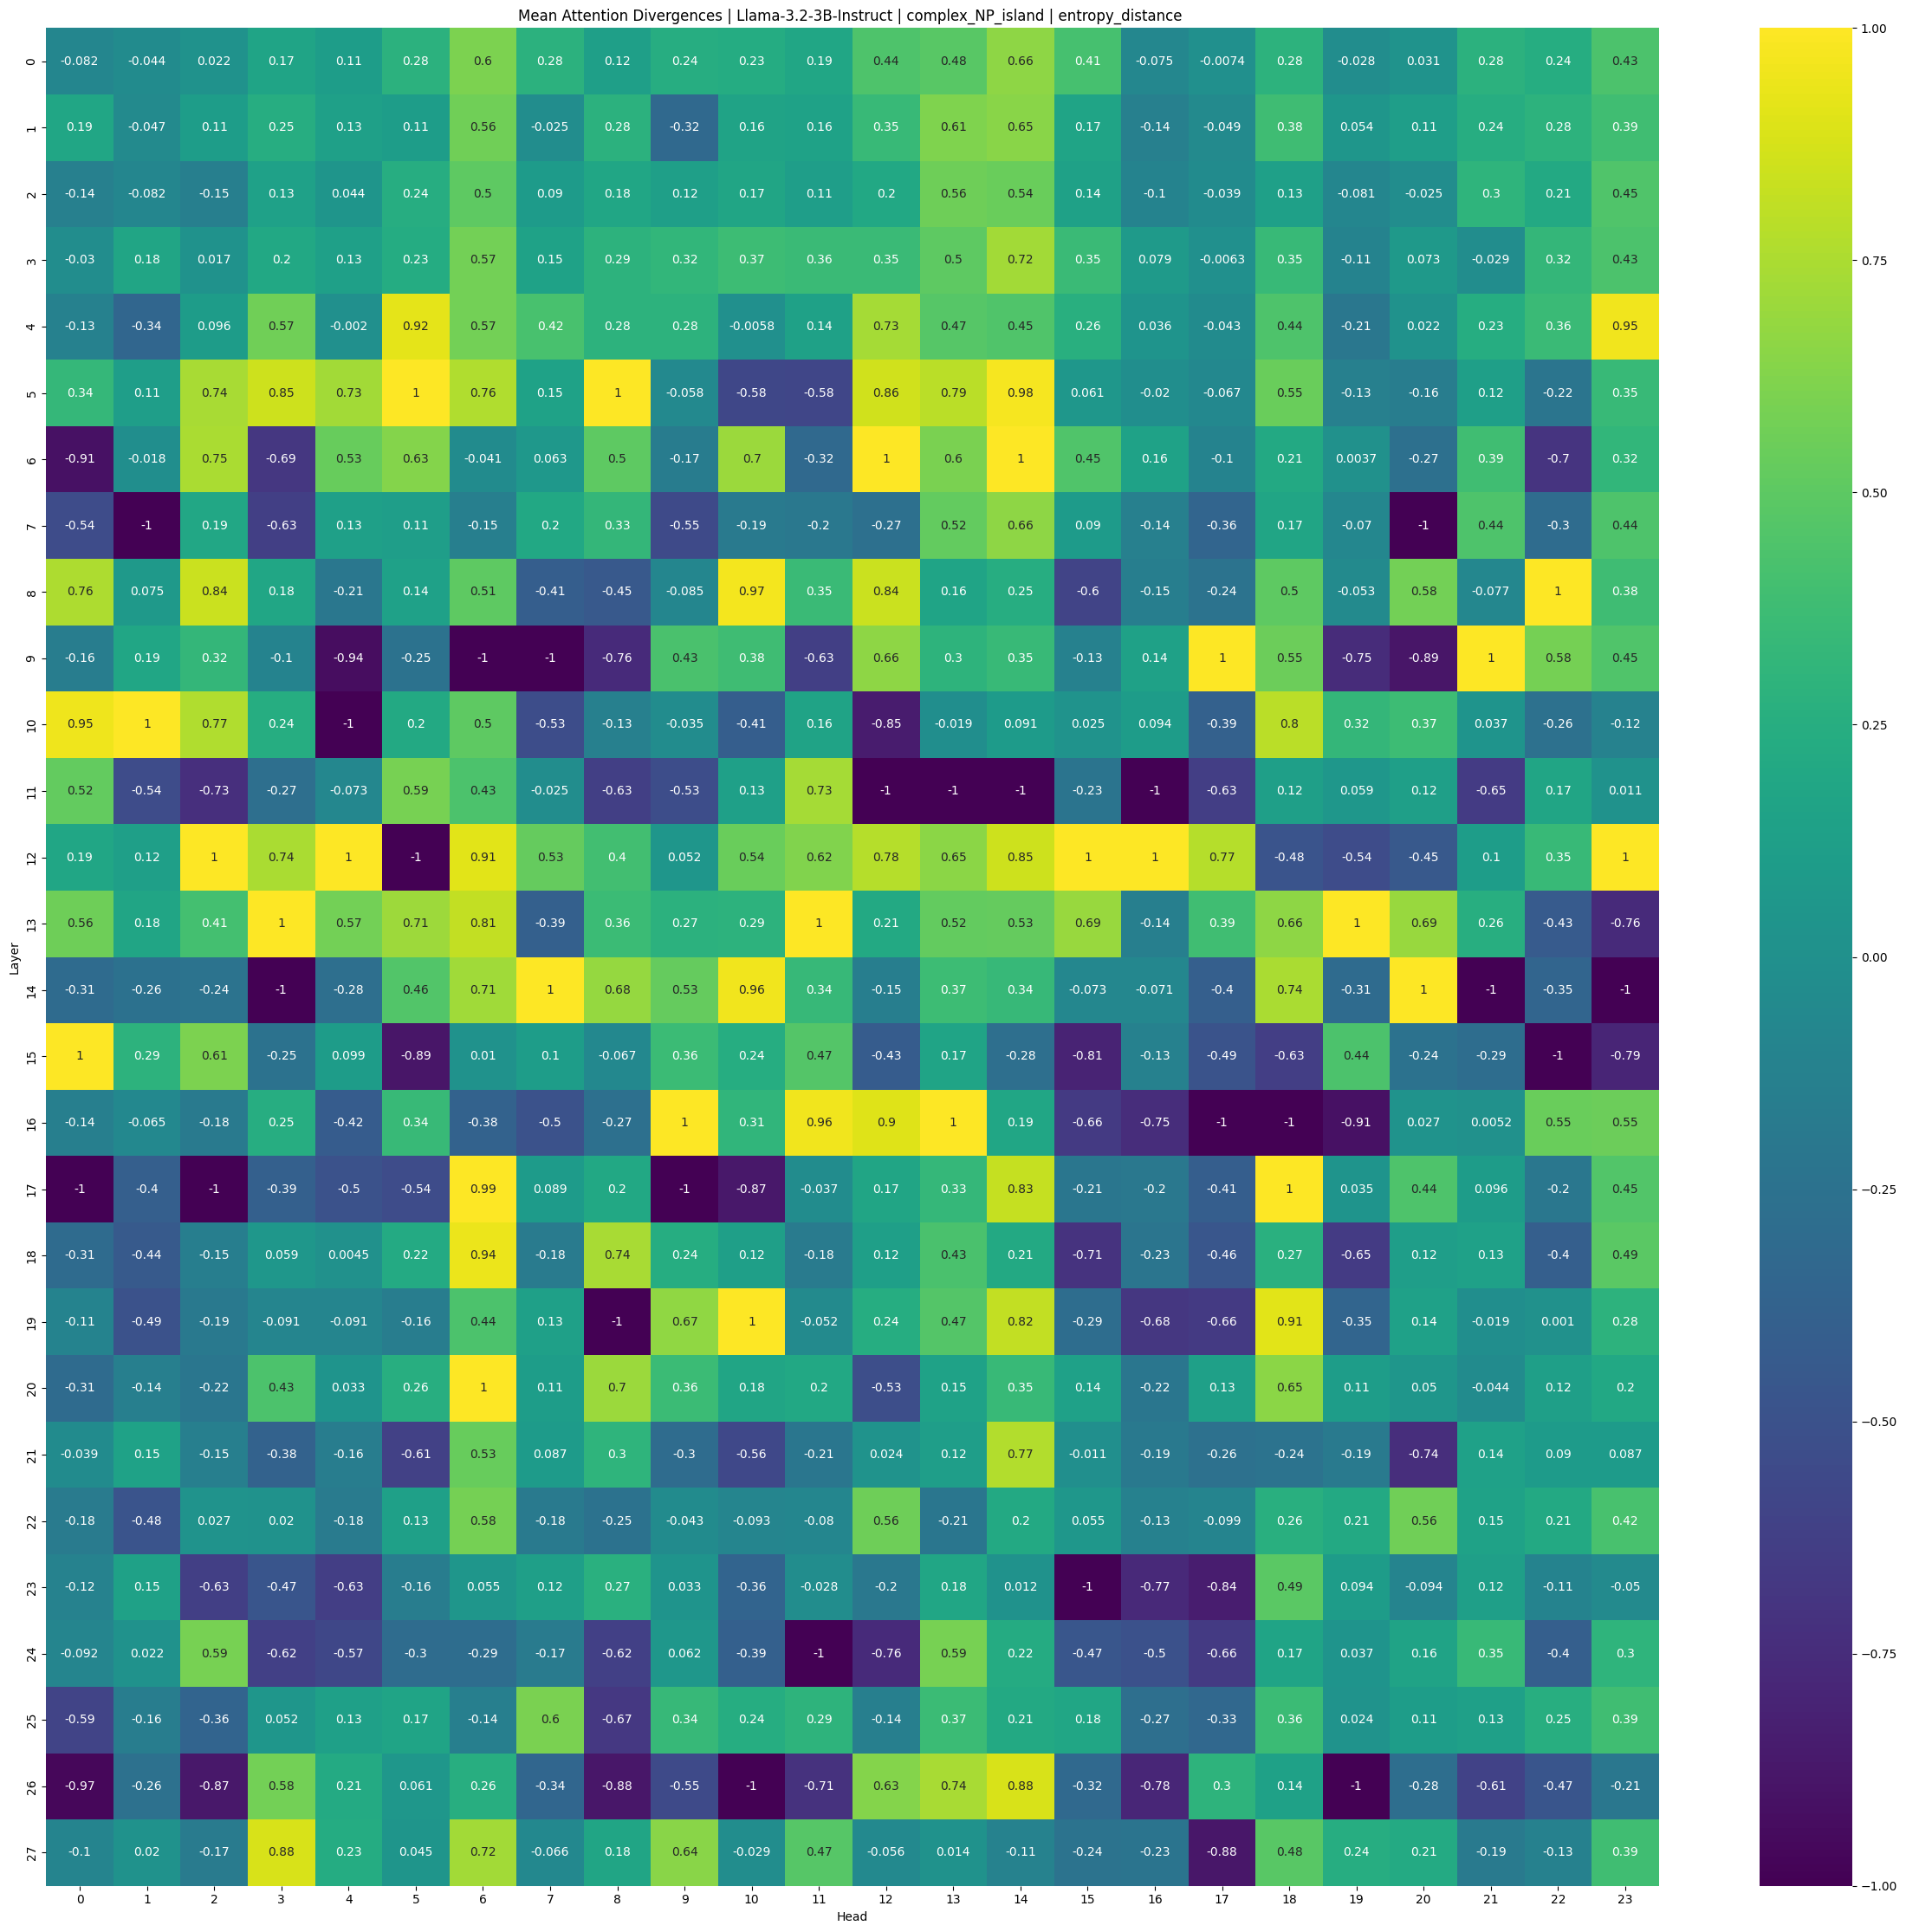

In [15]:
plot_attention_divergences('Llama-3.2-3B-Instruct', 'complex_NP_island', entropy_distance, True)

1000


1000it [00:04, 209.82it/s]


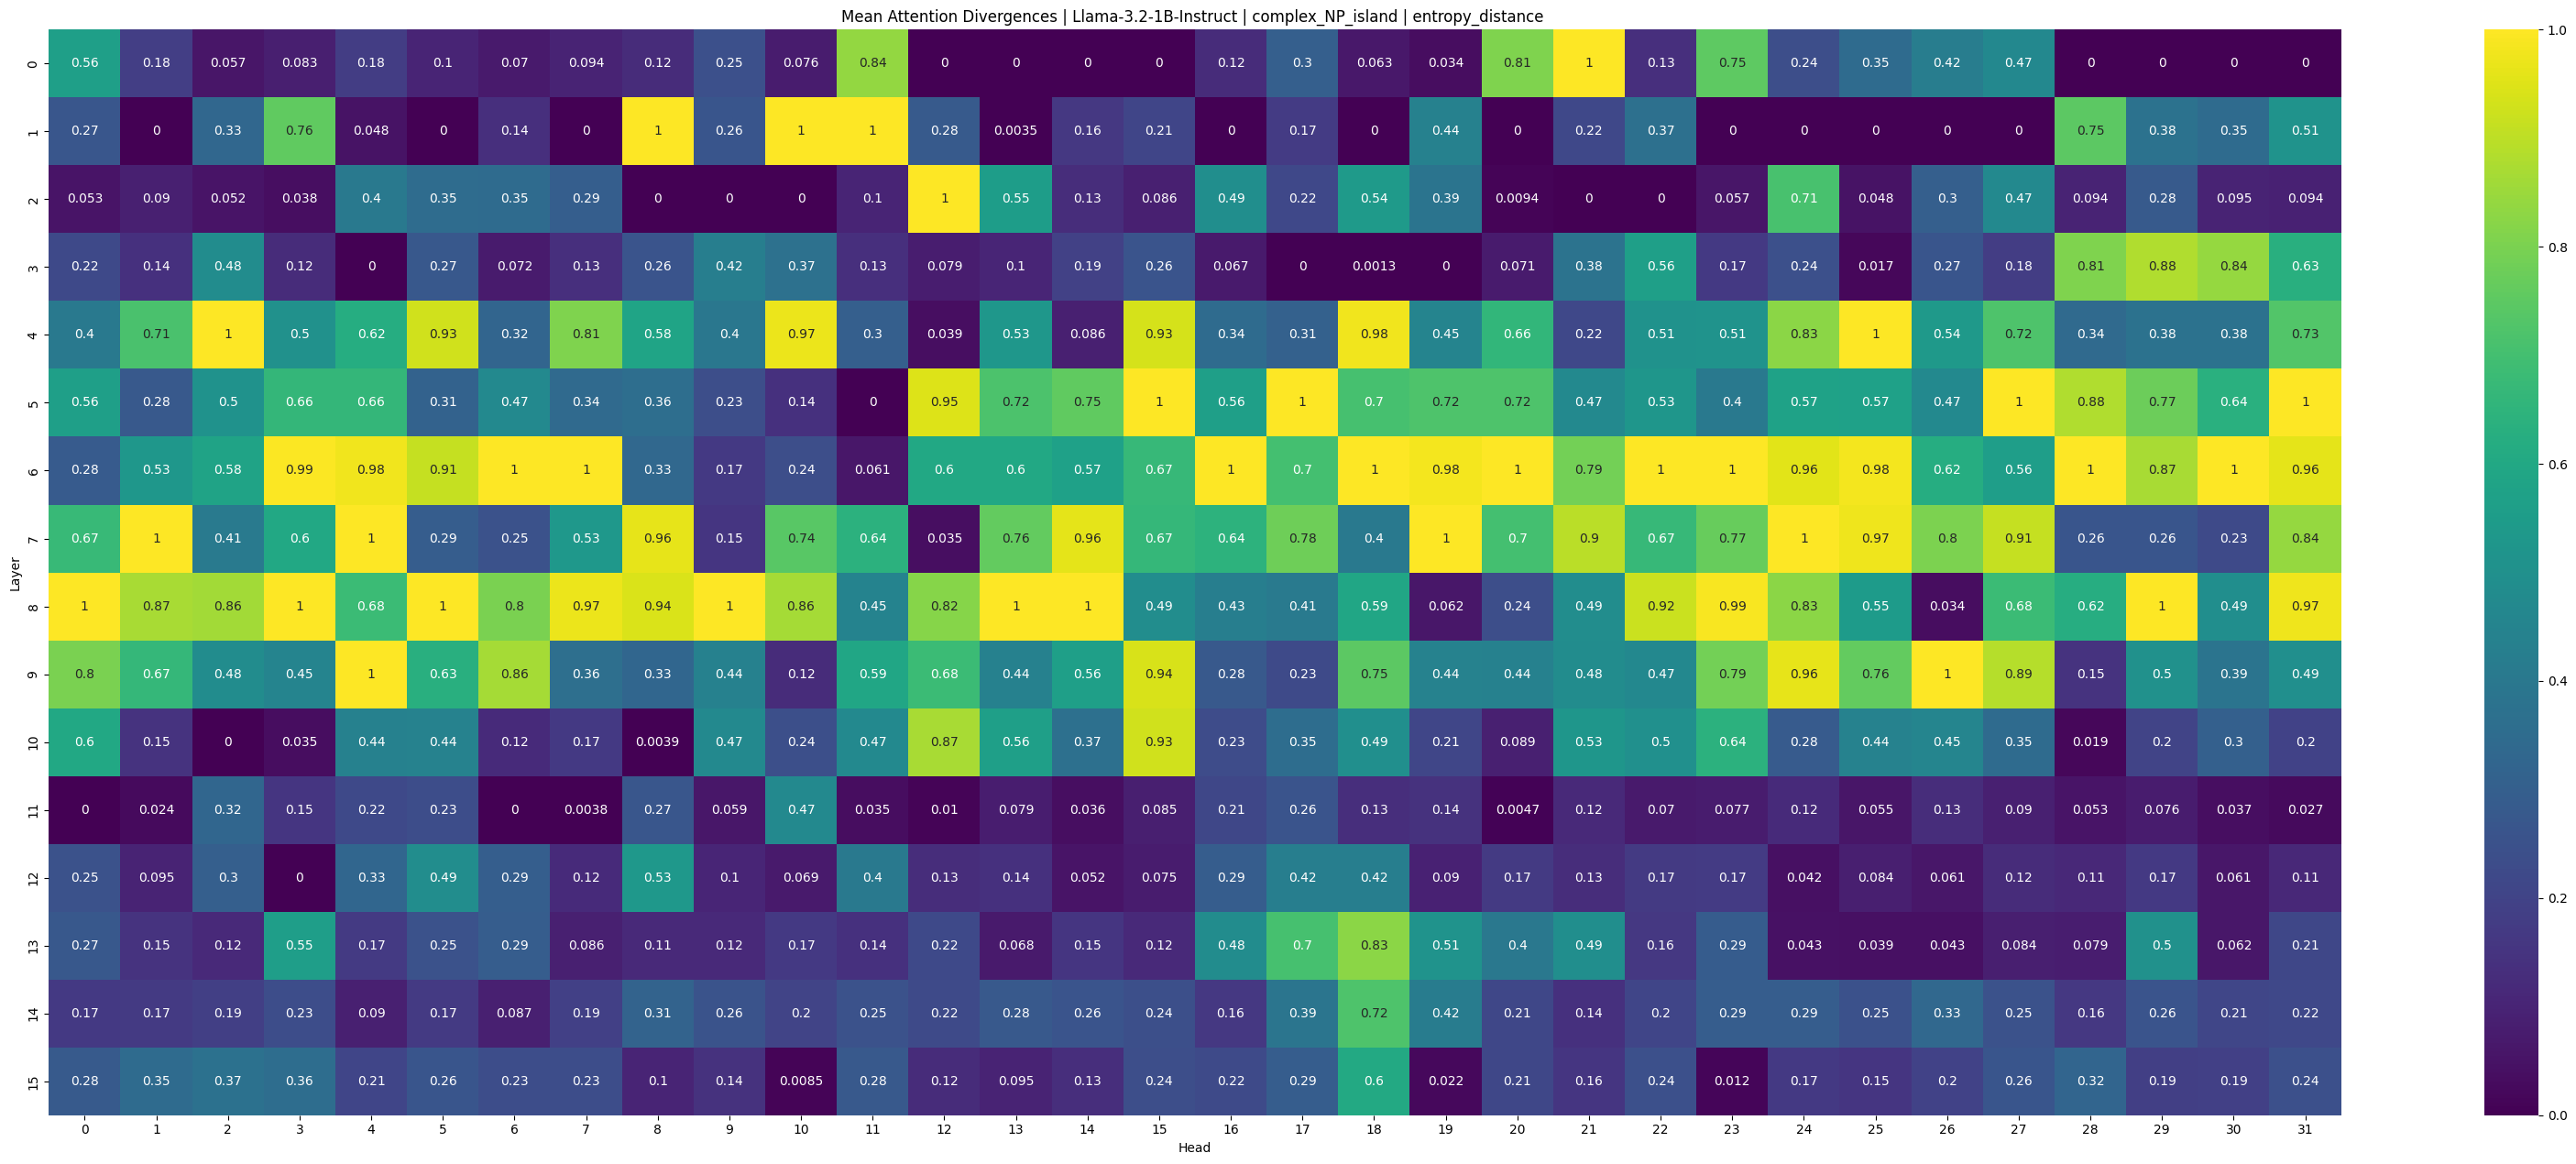

In [25]:
plot_attention_divergences('Llama-3.2-1B-Instruct', 'complex_NP_island', entropy_distance, True)

1000


1000it [00:09, 105.33it/s]


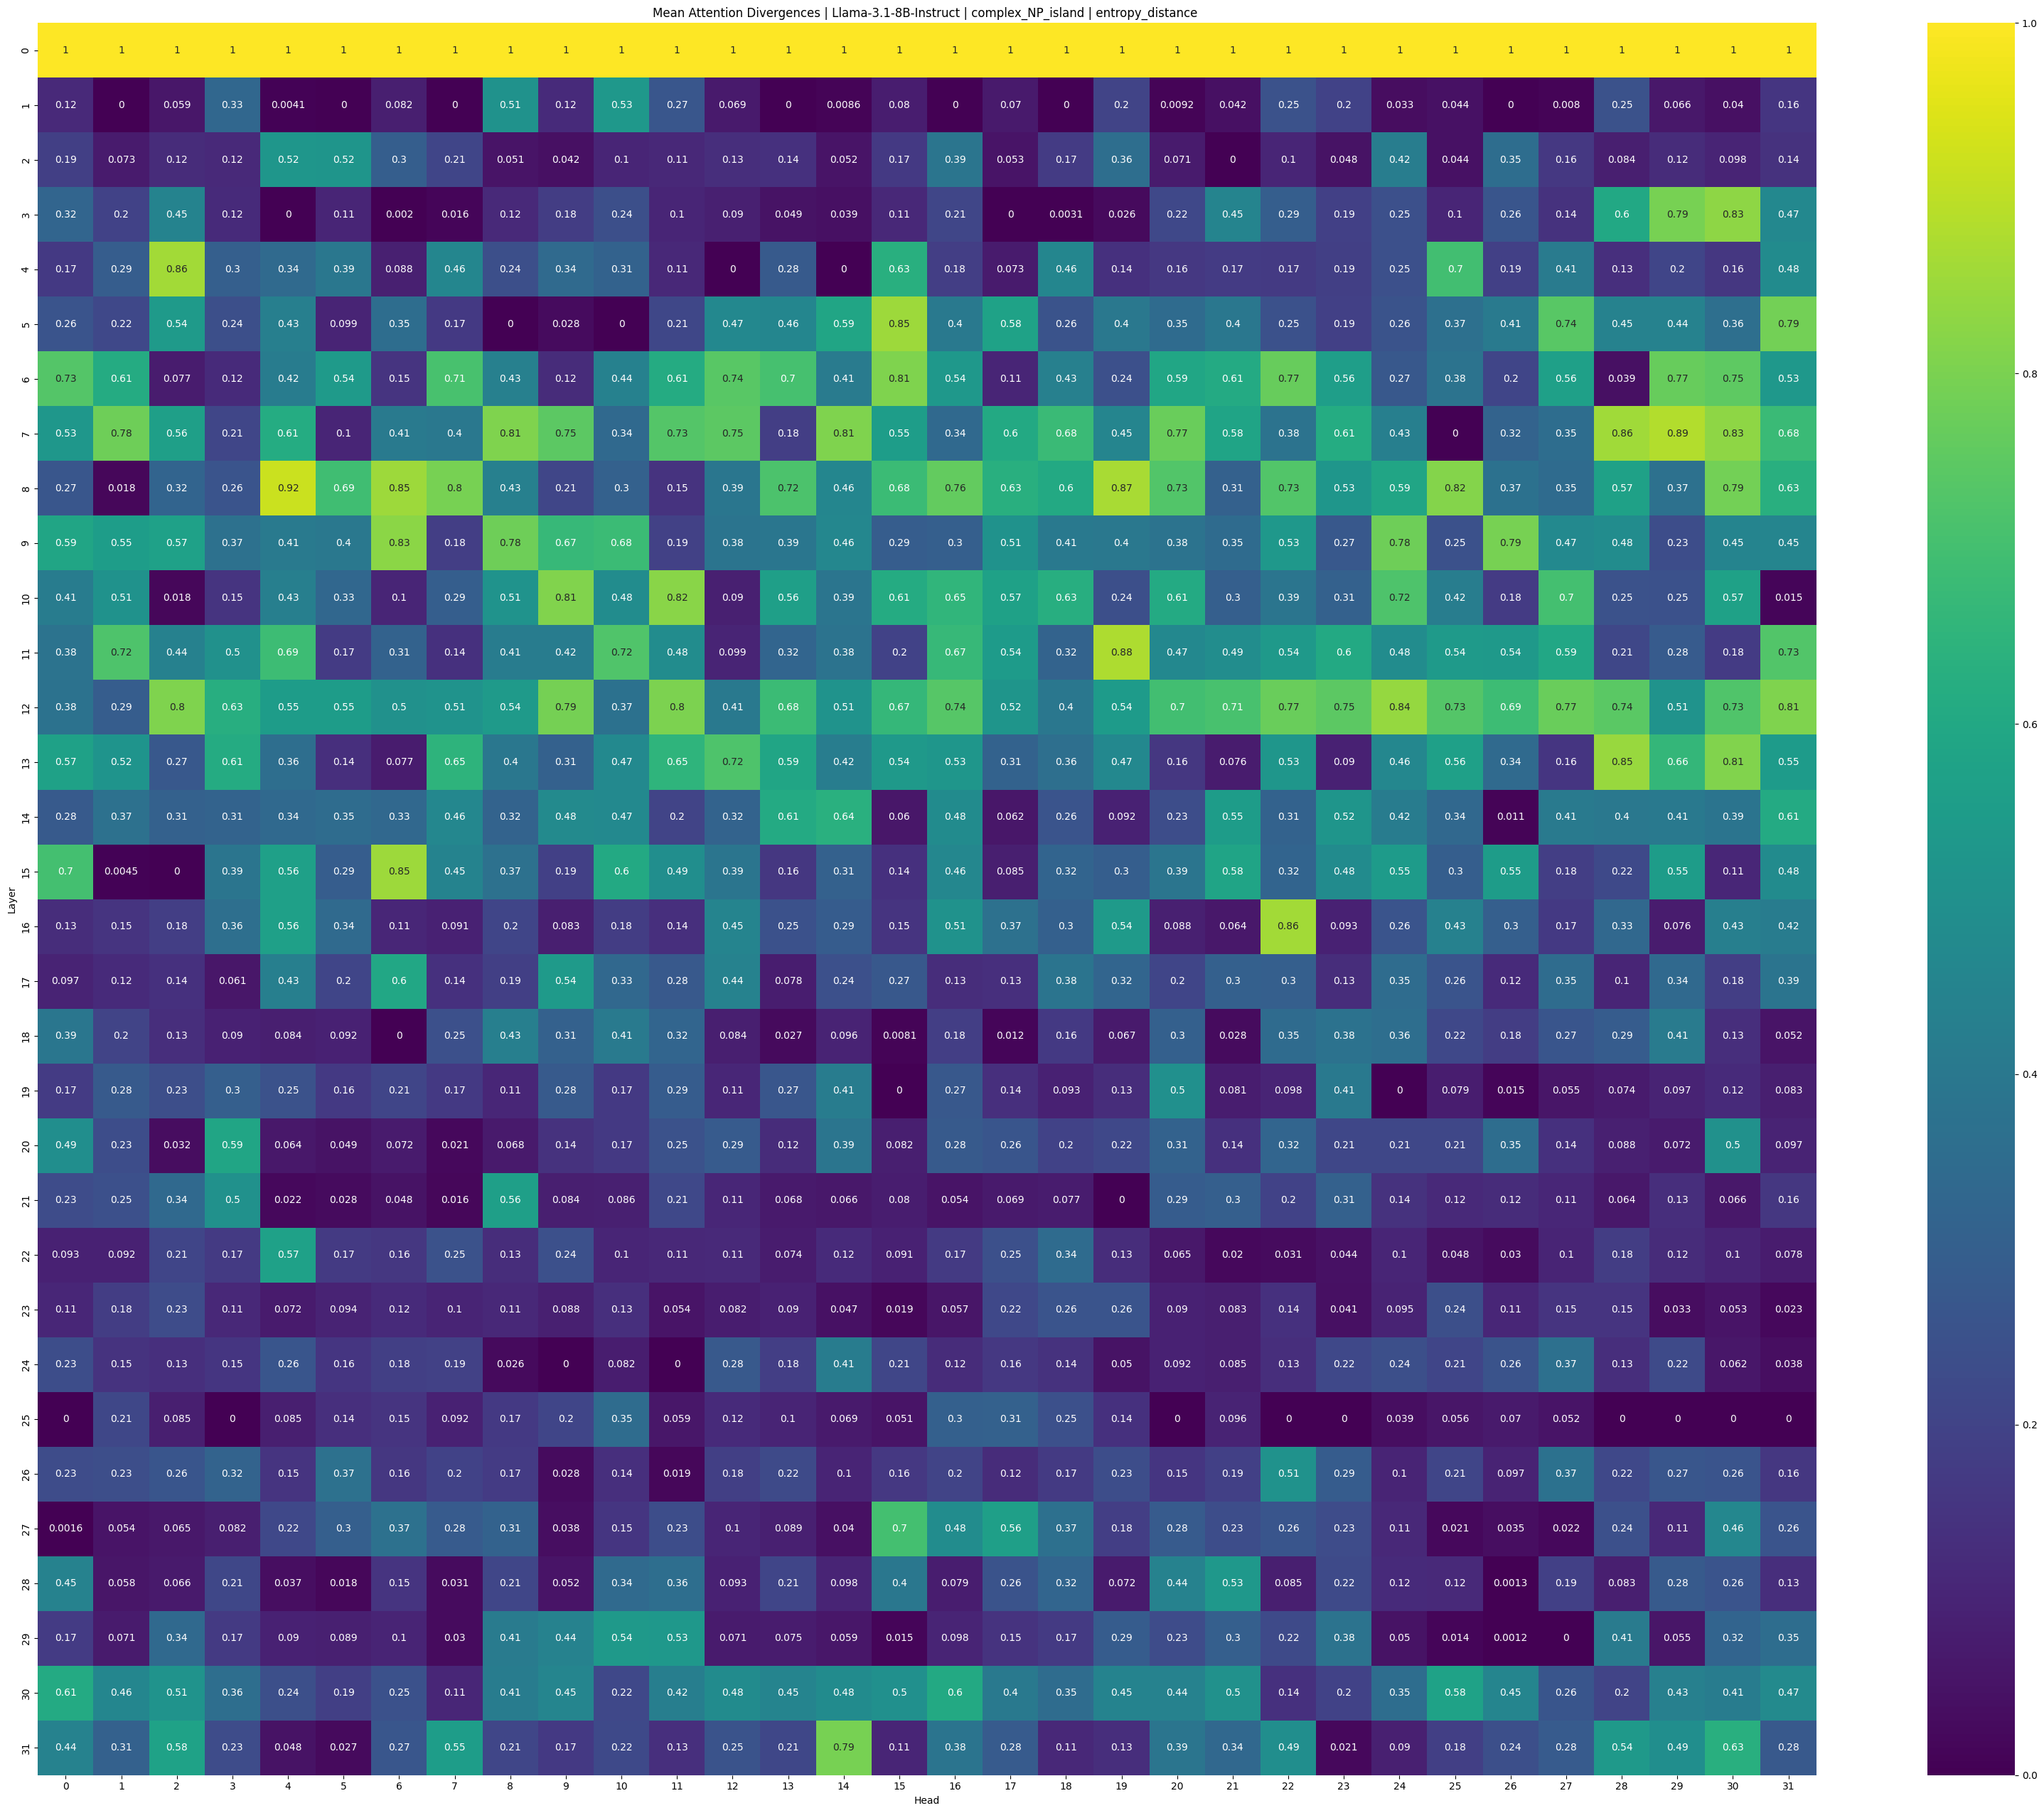

In [29]:
plot_attention_divergences('Llama-3.1-8B-Instruct', 'complex_NP_island', entropy_distance, True)

1000


1000it [00:13, 76.31it/s]


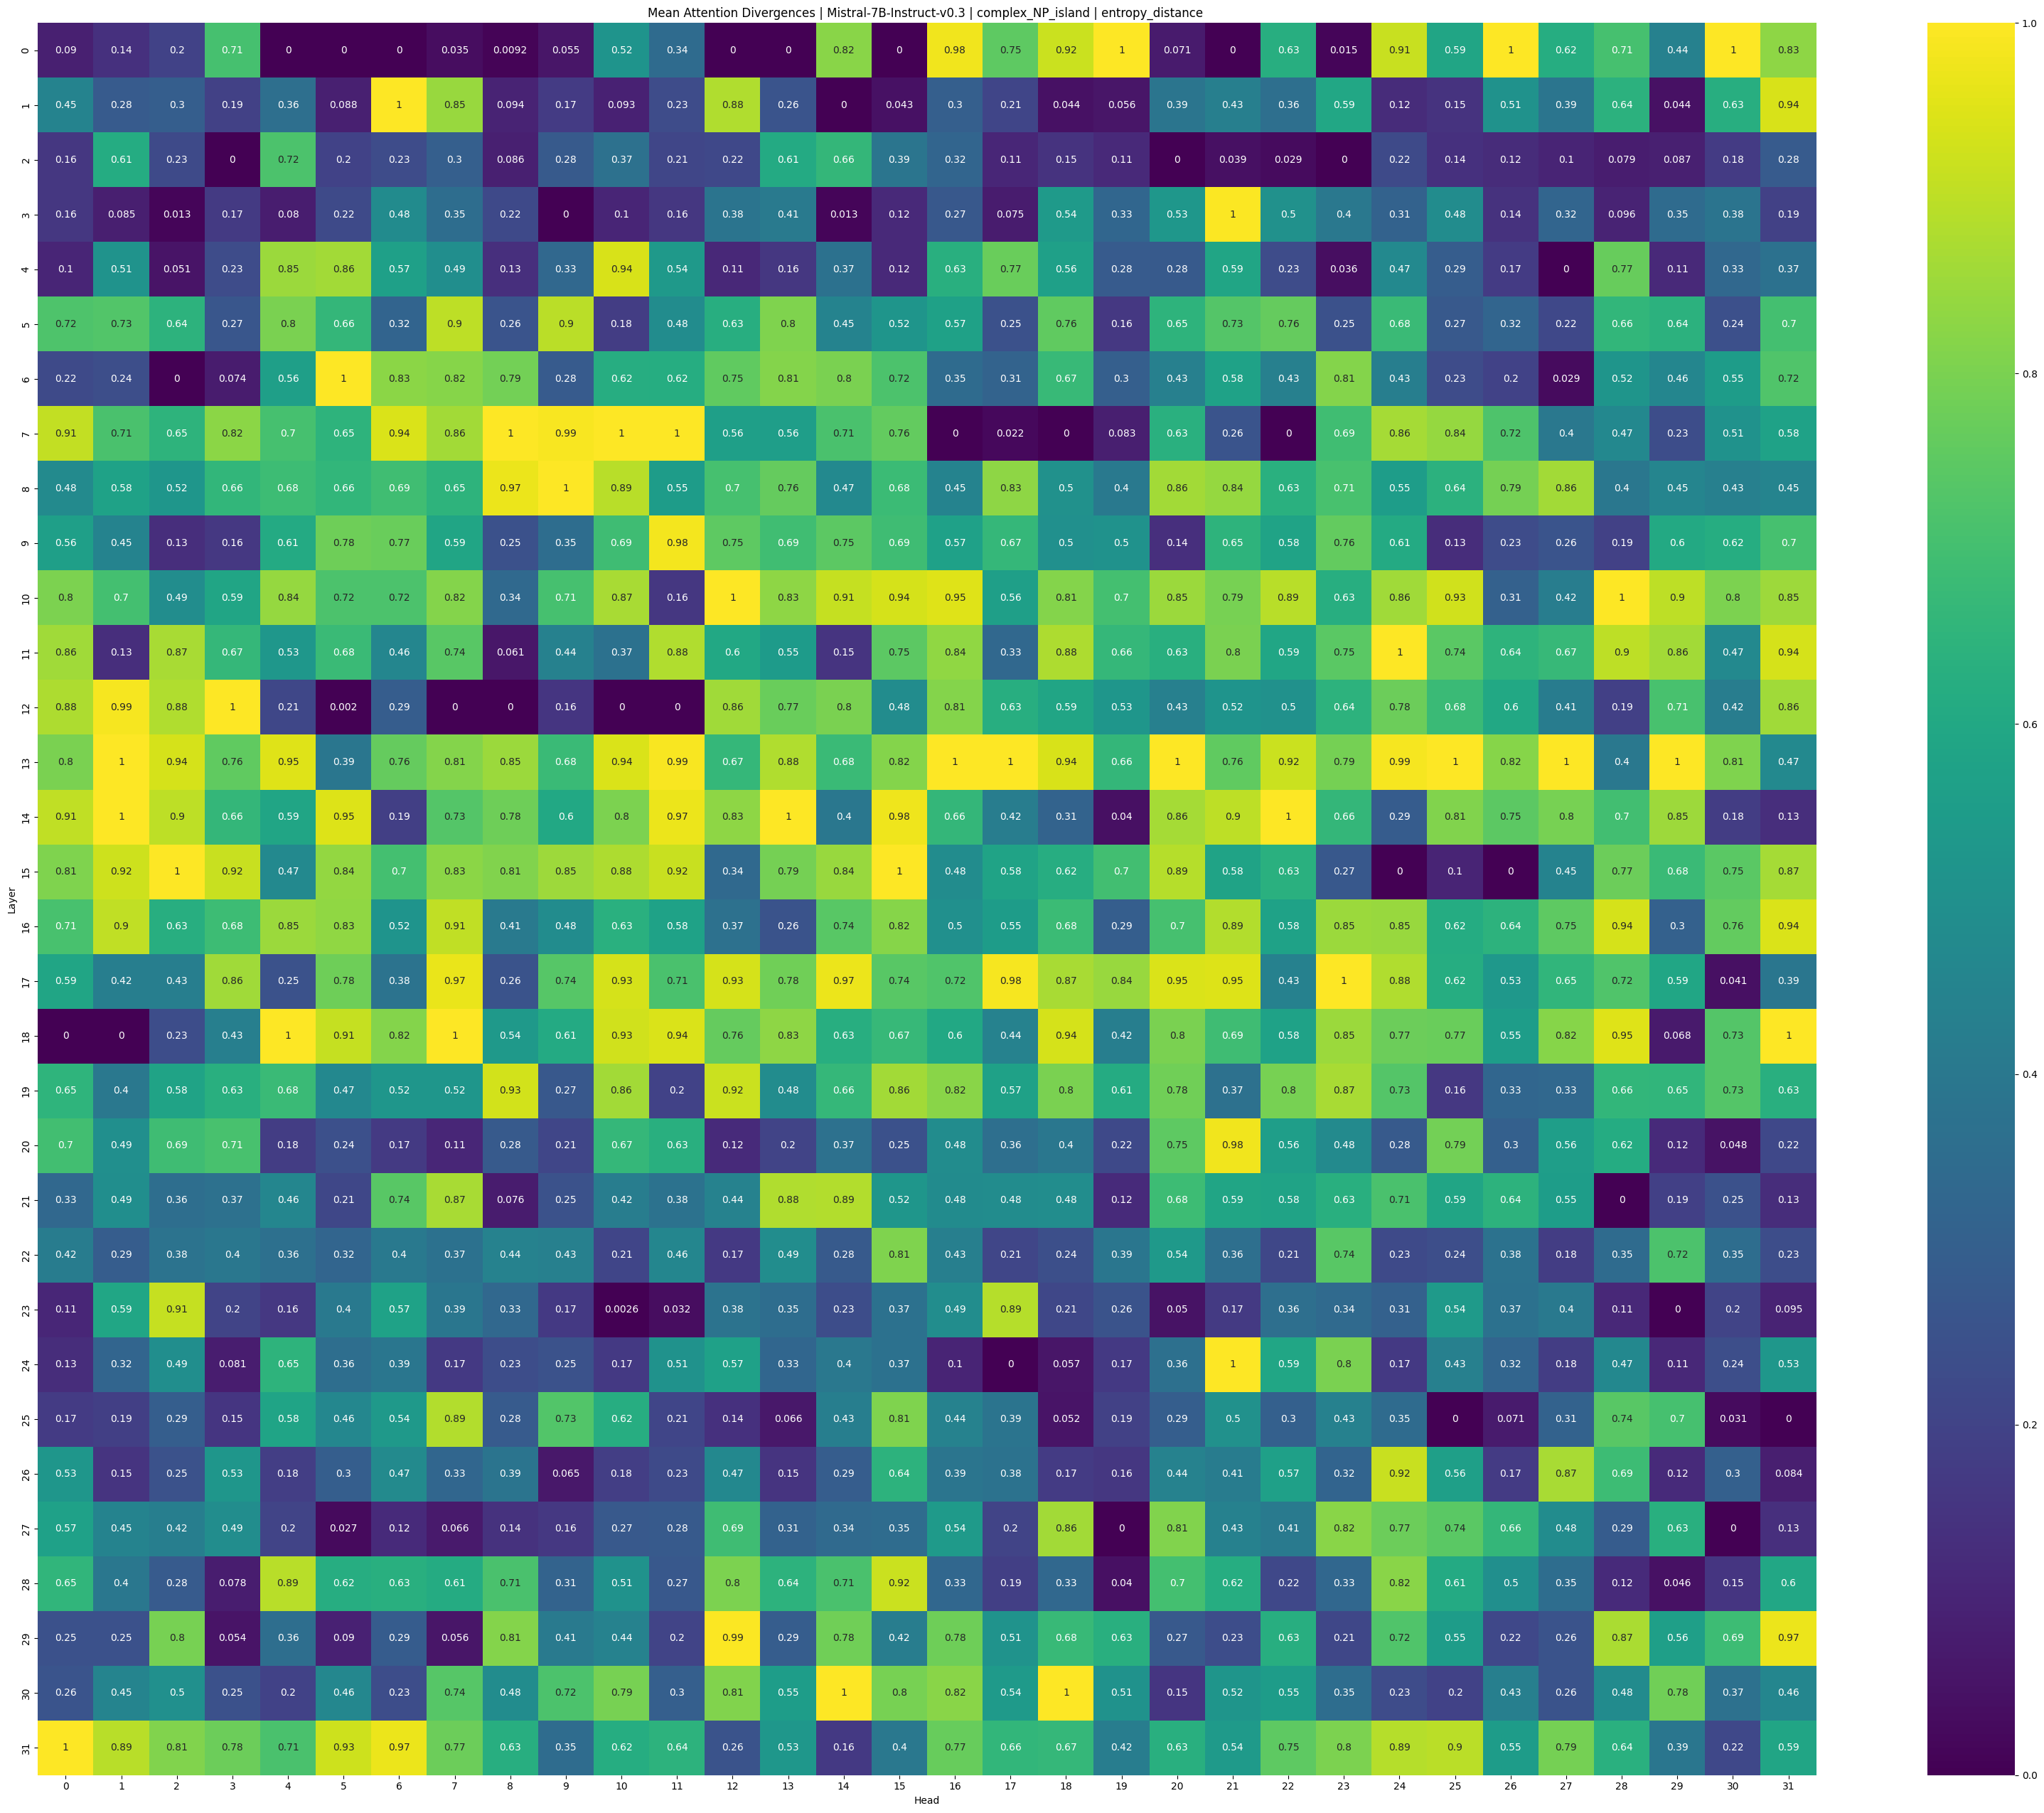

In [26]:
plot_attention_divergences('Mistral-7B-Instruct-v0.3', 'complex_NP_island', dist_func=entropy_distance, normalize=True)

1000


1000it [00:05, 181.00it/s]


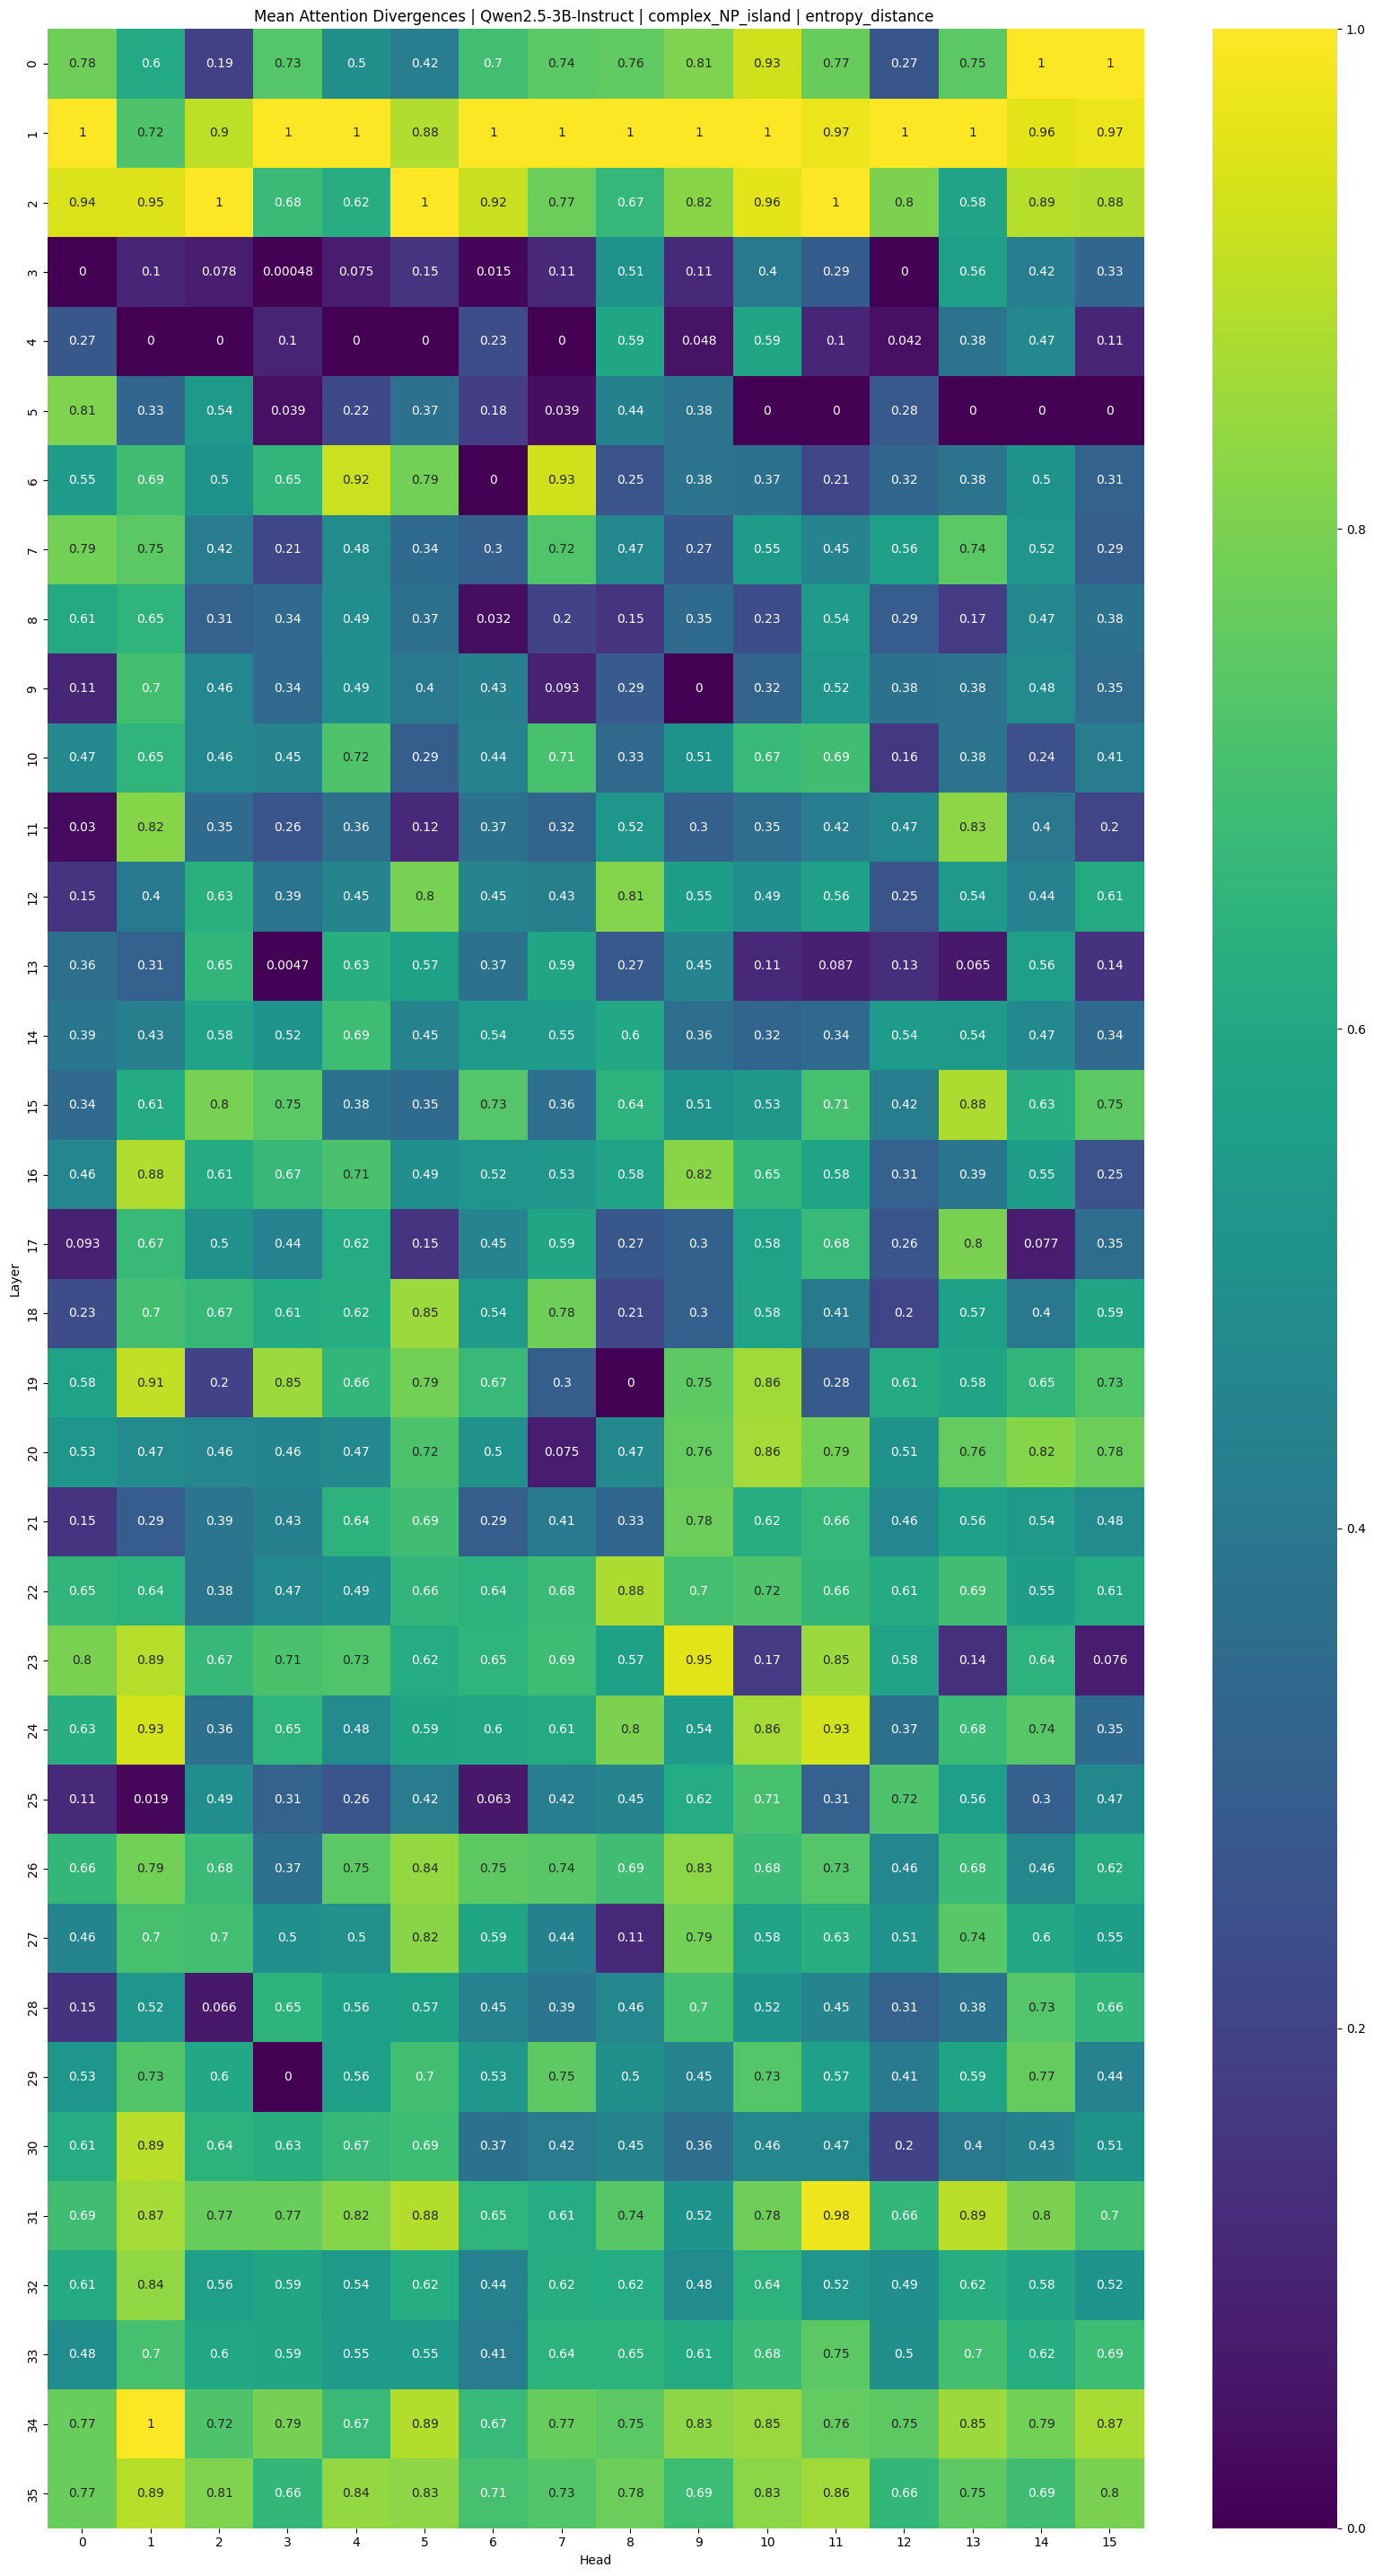

In [27]:
plot_attention_divergences('Qwen2.5-3B-Instruct', 'complex_NP_island', dist_func=entropy_distance, normalize=True)

1000


1000it [00:13, 76.02it/s]


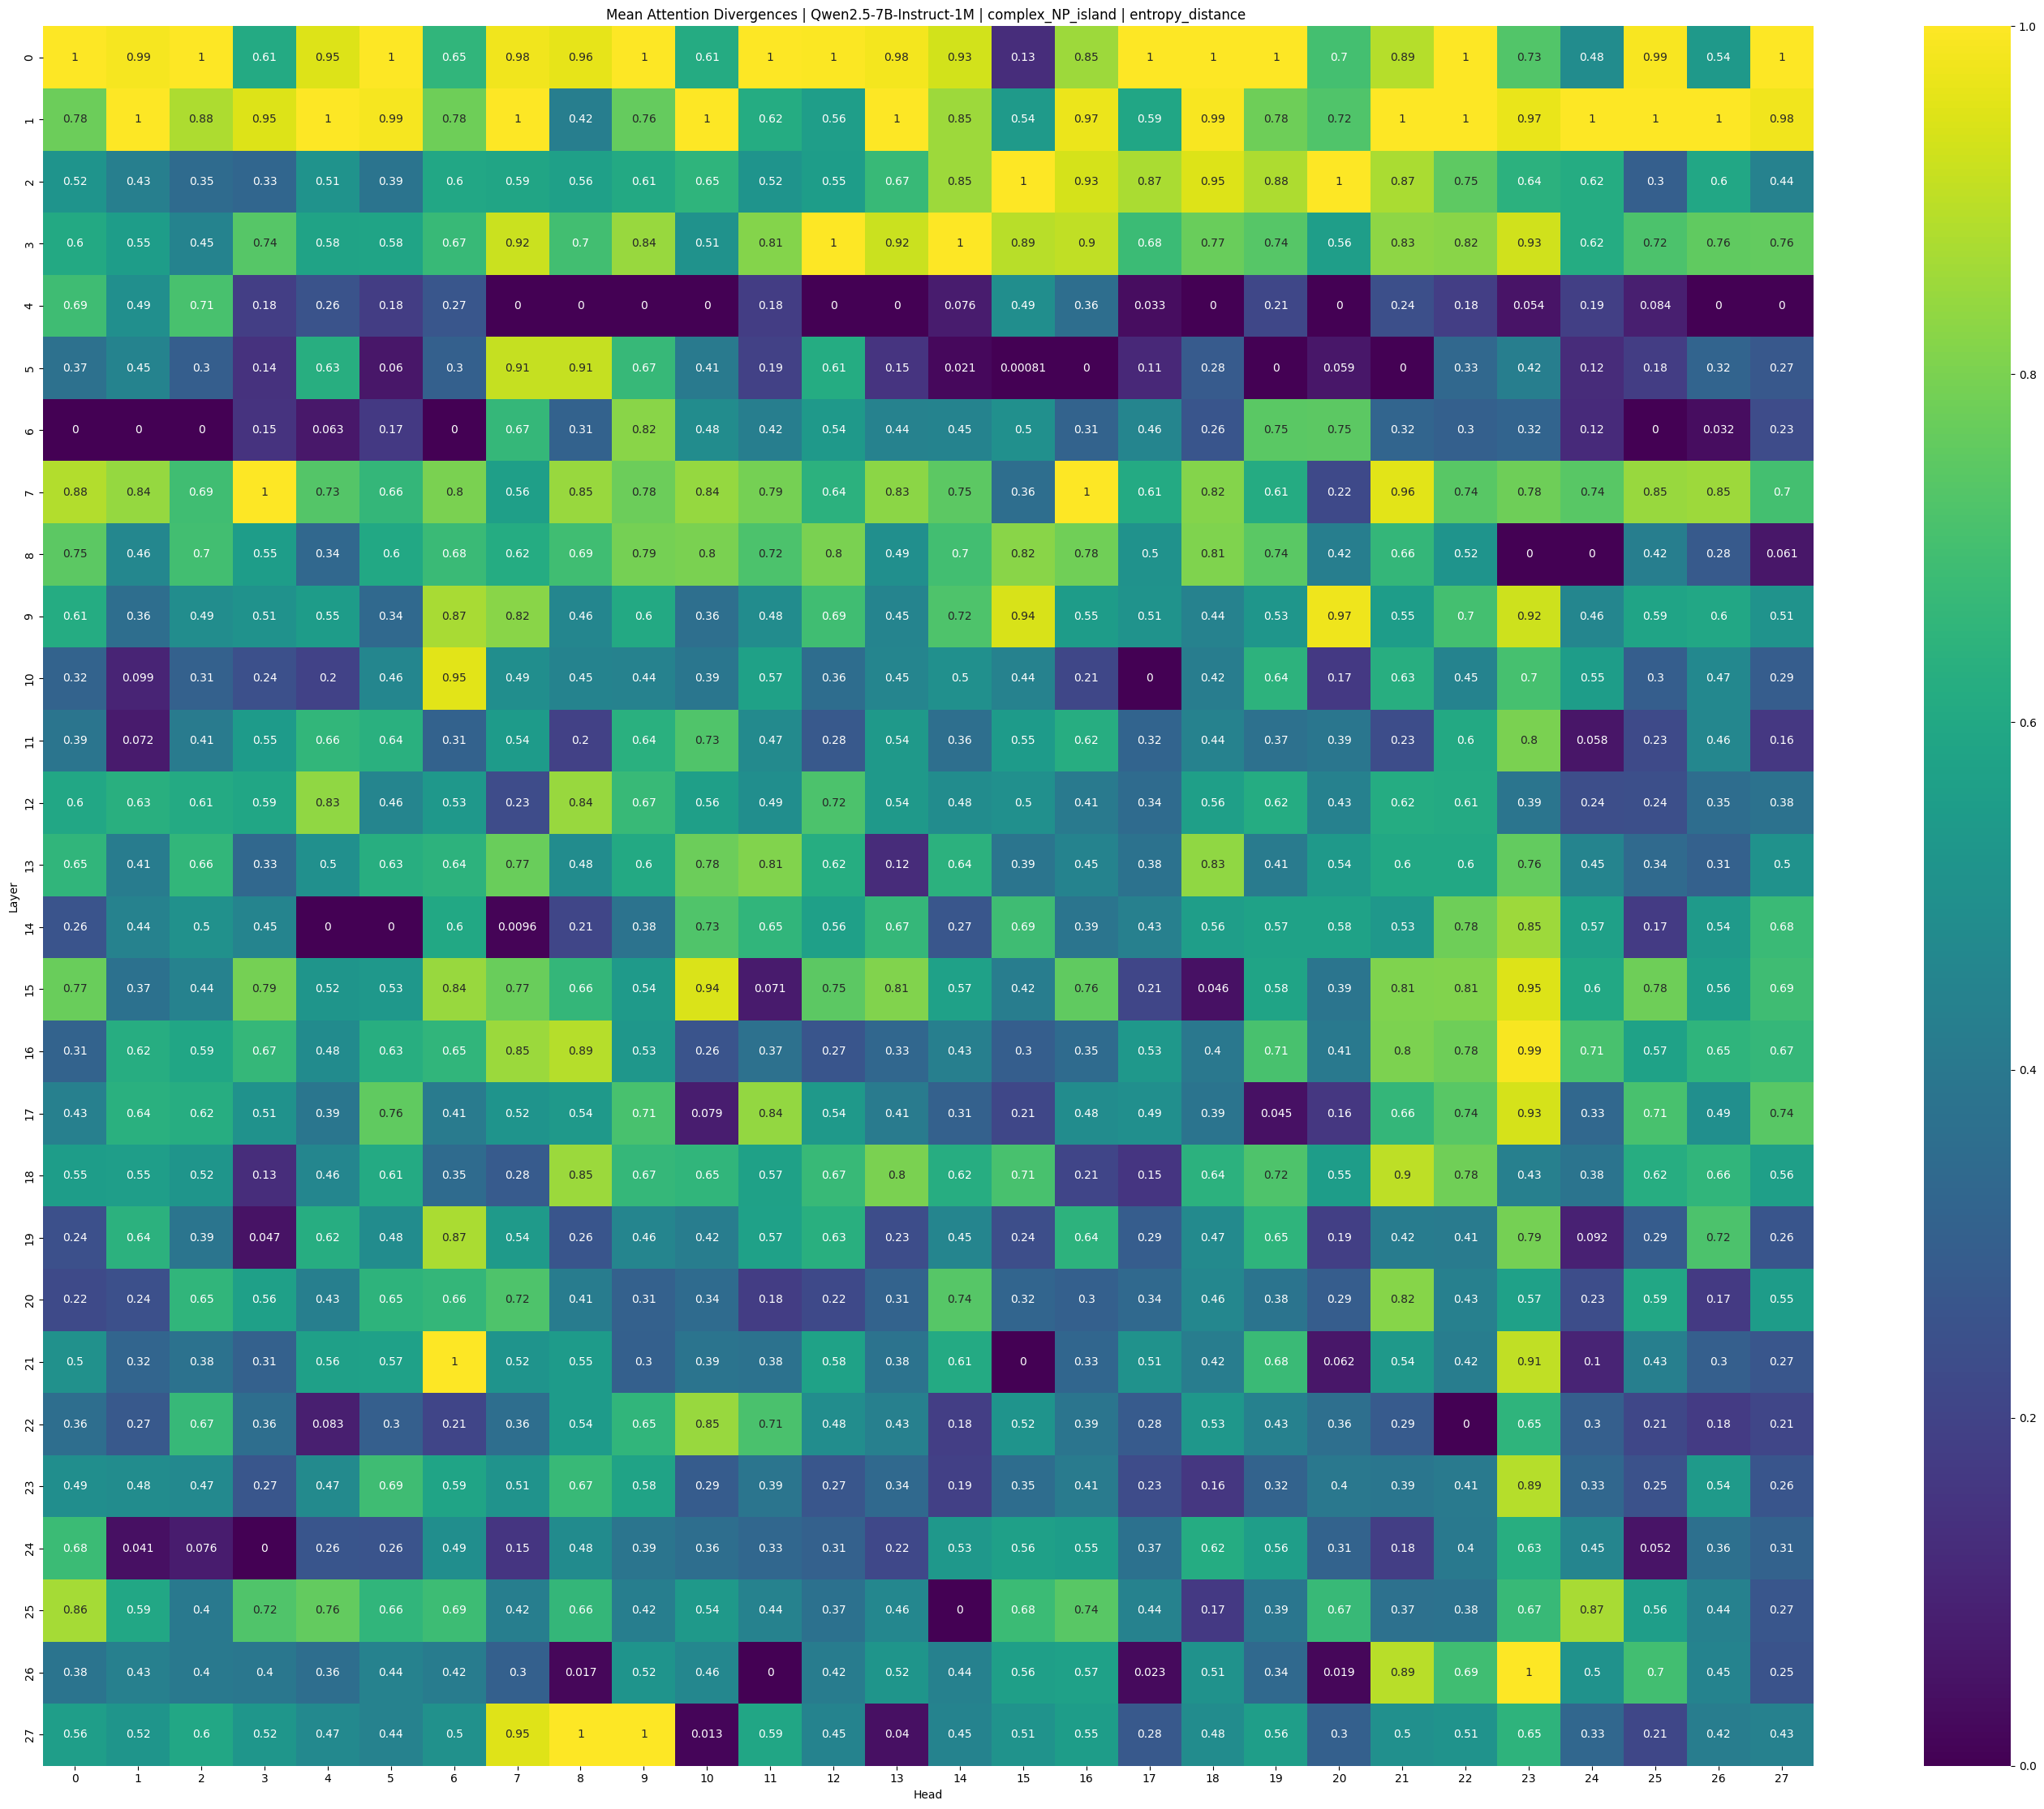

In [28]:
plot_attention_divergences('Qwen2.5-7B-Instruct-1M', 'complex_NP_island', dist_func=entropy_distance, normalize=True)